In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import os

def get_data(dataset):
    """Read hd5 data files to pandas df"""
    path = f'/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/{dataset}/df_ml_inputs.hd5'
    return pd.read_hdf(path)

def get_data_new(dataset):
    """Read hd5 data files to pandas df"""
    path = f"/scratch/ys20884/ml_vars/{dataset}/df_ml_inputs.hd5"
    return pd.read_hdf(path)

def get_obj_features(data):
    # Feature engineering
    object_cols = ['cleanedJet_eta', 'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt', 'cleanedJet_chHEF', 'cleanedJet_area']
    # dict of names
    names = {0:'Leading', 1:'Secondary', 2:'Third', 3:'Fourth'}
    for col in object_cols:
        for jet in range(4):
            name = f'{names[jet]} {col}'
            data[name] = data.apply(lambda x:x[col][jet] if jet < x['ncleanedJet'] else None, axis=1)
    return data

def preprocess(train_size=0.8, datasets=None, new=False):
    # datasets = ['ttH125', 'TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
    if not datasets:
        datasets = os.listdir('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/')
    # Combine datasets
    if new:
        data = pd.concat([get_data_new(dataset) for dataset in datasets if dataset != "test"], ignore_index=True)
    else:
        data = pd.concat([get_data(dataset) for dataset in datasets if dataset != "test"], ignore_index=True)
    # Combine QCD, W/Z jet backgrounds into single labels (i.e. ignore HT cut in label)
    new_cols = {"QCD":"QCD", "Jets":"VJets", "WminusH125": "VH125", "WplusH125":"VH125", "ZH125":"VH125"}
    for col in new_cols:
        data['dataset'] = data.dataset.str.replace(r'(^.*' + col + r'.*$)', new_cols[col])
    # Labels (make individual columns of ones and zeros for each category)
    labels = pd.get_dummies(data['dataset'])
    # data = data.join(labels)
    # separate features from labels
    X, y = data.drop(['weight_nominal', 'entry', 'hashed_filename', 'MHT_phi', 'InputMet_phi', 'dataset', 'BiasedDPhi'], axis=1), labels
    # print(labels)
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)
    weights = [X_train['xs_weight'], X_test['xs_weight']]
    X_train, X_test = X_train.drop('xs_weight', axis=1), X_test.drop('xs_weight', axis=1)
    # Save non scaled train and test for analysis
    # X_train.to_hdf("./X_train_combined.hd5", key="train")
    # X_test.to_hdf("./X_test_combined.hd5", key="test")
    # Feature scaling for event level variables
    X_train_event, X_test_event = X_train.select_dtypes(exclude=object), X_test.select_dtypes(exclude=object)
    event_scaler = StandardScaler()
    X_train_event_scaled = event_scaler.fit_transform(X_train_event)
    X_test_event_scaled = event_scaler.transform(X_test_event)
    print("scaled event")
    # Get object level data
    X_train_obj, X_test_obj = get_object_data(X_train.select_dtypes(object), 14), get_object_data(X_test.select_dtypes(object), 14)
    object_scaler = StandardScaler()
    nz_train, nz_test = np.any(X_train_obj, -1), np.any(X_test_obj, -1)
    X_train_obj[nz_train] = object_scaler.fit_transform(X_train_obj[nz_train])
    X_test_obj[nz_test] = object_scaler.transform(X_test_obj[nz_test])
    print("scaled object")
    np.nan_to_num(X_train_obj, copy=False, nan=0)
    np.nan_to_num(X_test_obj, copy=False, nan=0)
    return np.array([X_train_event_scaled, X_test_event_scaled, X_train_obj, X_test_obj, y_train, y_test]), weights

def get_object_data(inp_data, max_jets):
    num_samples = len(inp_data)
    num_cols = len(inp_data.columns)
    data = np.zeros((num_samples, max_jets, num_cols))
    for i in range(max_jets):
        for j in range(num_cols):
            if j == 6 and i > 0:
                data[:, i, j] = inp_data.iloc[:, j].map(lambda x: abs(x[i] - x[0]) if len(x) > i else np.nan)
            else:
                data[:, i, j] = inp_data.iloc[:, j].map(lambda x: x[i] if len(x) > i else np.nan)
    return data

def get_object_data_new(inp_data, max_jets):
    num_samples = len(inp_data)
    num_cols = 11
    # regular jet collection
    reg_cols = ['cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt']
    data = np.zeros((num_samples, max_jets+9, num_cols))
    for i in range(max_jets):
        for j, col in enumerate(reg_cols):
            data[:, i, j] = inp_data.loc[:, col].map(lambda x: x[i] if len(x) > i else np.nan)
    # b jets
    bjet_cols = ['cleanedBJet_eta',
       'cleanedBJet_phi', 'cleanedBJet_pt']
    for i in range(3):
        for j, col in enumerate(bjet_cols):
            data[:, 14+i, j] = inp_data.loc[:, col].map(lambda x: x[i] if len(x) > i else np.nan)


        
    
    


In [10]:
df = get_data_new("ttH125")

AttributeError: 'DataFrame' object has no attribute 'key'

In [9]:
data.loc[:, 'cleanedJet_area']

0         [0.4987793, 0.50878906, 0.5185547, 0.5185547, ...
1         [0.4987793, 0.47875977, 0.48876953, 0.5288086,...
2         [0.47875977, 0.47875977, 0.48876953, 0.5087890...
3         [0.50878906, 0.50878906, 0.50878906, 0.5185547...
4         [0.50878906, 0.46875, 0.5185547, 0.48876953, 0...
                                ...                        
881091                    [0.48876953, 0.50878906, 0.46875]
881092                              [0.50878906, 0.5385742]
881093    [0.5185547, 0.47875977, 0.48876953, 0.46875, 0...
881094    [0.5185547, 0.4387207, 0.54833984, 0.4987793, ...
881095    [0.5185547, 0.5288086, 0.47875977, 0.50878906,...
Name: cleanedJet_area, Length: 881096, dtype: object

In [10]:
data["ncleanedBJet"].max()

7

In [22]:
df.columns

Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'boostedObject_area', 'boostedObject_eta', 'boostedObject_mass',
       'boostedObject_phi', 'boostedObject_pt', 'boostedTop_area',
       'boostedTop_eta', 'boostedTop_mass', 'boostedTop_phi', 'boostedTop_pt',
       'boostedTop_tag', 'boostedV_area', 'boostedV_eta', 'boostedV_mass',
       'boostedV_phi', 'boostedV_pt', 'boostedV_tag', 'cleanedBJet_eta',
       'cleanedBJet_phi', 'cleanedBJet_pt', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')

In [ ]:
df

In [2]:
datasets = ["ttH125", "TTToHadronic", "TTToSemiLeptonic", "TTTo2L2Nu"]
data = pd.concat([get_data_new(dataset) for dataset in datasets], ignore_index=True)

In [3]:
data["nboosted"] = data["boostedObject_pt"].map(lambda x: len(x))

In [8]:
data.select_dtypes(object).columns

Index(['dataset', 'boostedObject_area', 'boostedObject_eta',
       'boostedObject_mass', 'boostedObject_phi', 'boostedObject_pt',
       'boostedTop_area', 'boostedTop_eta', 'boostedTop_mass',
       'boostedTop_phi', 'boostedTop_pt', 'boostedTop_tag', 'boostedV_area',
       'boostedV_eta', 'boostedV_mass', 'boostedV_phi', 'boostedV_pt',
       'boostedV_tag', 'cleanedBJet_eta', 'cleanedBJet_phi', 'cleanedBJet_pt',
       'cleanedJet_area', 'cleanedJet_btagDeepB', 'cleanedJet_chHEF',
       'cleanedJet_eta', 'cleanedJet_mass', 'cleanedJet_neHEF',
       'cleanedJet_phi', 'cleanedJet_pt'],
      dtype='object')

<AxesSubplot:xlabel='nboosted', ylabel='Density'>

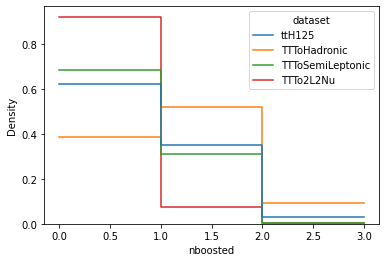

In [6]:
import seaborn as sns

sns.histplot(data, x="nboosted", hue="dataset", stat="density", common_norm=False, element='step', fill=False, bins=range(4))

In [47]:
# boosted_events = data['boostedObject_pt'].map(lambda x: len(x) > 0)
data[boosted_events]['boostedObject_pt'].map(lambda x: x[0]) >= data[boosted_events]["cleanedJet_pt"].map(lambda x: max(x))

6          True
8          True
9          True
14         True
17        False
          ...  
881054     True
881062     True
881063    False
881068    False
881075     True
Length: 282386, dtype: bool

In [42]:
len(data[(data["dataset"] == "ttH125") & (len(data['boostedV_tag']) > 0)])

177858

In [8]:
data.loc[data["dataset"] == "ttH125", "dataset"] = "invisible higgs"
data.loc[data["dataset"] == "TTToHadronic", "dataset"] = r"$t\bart$ fully hadronic"
data.loc[data["dataset"] == "TTToSemiLeptonic", "dataset"] = r"$t\bart$ semi leptonic"
data.loc[data["dataset"] == "TTTo2L2Nu", "dataset"] = r"$t\bart$ di leptonic"


In [9]:
set(data["dataset"])

{'$t\\bart$ di leptonic',
 '$t\\bart$ fully hadronic',
 '$t\\bart$ semi leptonic',
 'invisible higgs'}

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


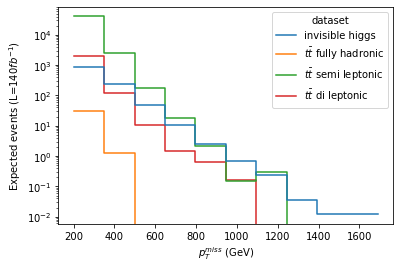

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

data["xs_weight"] *= 140e3
fig, ax = plt.subplots()
sns.histplot(data=data, x="InputMet_pt", hue="dataset", weights="xs_weight", stat="count", element="step", log_scale=(False, True), fill=False, ax=ax)
ax.set_ylabel(r"Expected events (L=$140fb^{-1}$)")
ax.set_xlabel(r"$p_{T}^{miss}$ (GeV)")
plt.savefig("../../pt_miss_140fb.png", dpi=200)
plt.show()

In [2]:
import pandas as pd
import os

path = "/scratch/ys20884/ml_vars/"
datasets = ["ttH125", "TTToHadronic", "TTToSemiLeptonic", "TTTo2L2Nu"]
data = pd.concat([pd.read_hdf(path+dataset+"/df_ml_inputs.hd5") for dataset in datasets])
data.describe()

,entry,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_phi,InputMet_pt,MHT_phi,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,hashed_filename,ncleanedBJet,ncleanedJet,weight_nominal,xs_weight
count,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,881096.000000,8.810960e+05,881096.000000,881096.000000,8.810960e+05,8.810960e+05
mean,118170.220773,2.082170,338.269213,607.474854,1.058414,0.080815,279.387329,0.061919,276.380859,0.906002,0.734593,0.426275,4.977714e+17,0.822242,4.853666,7.399070e-07,8.492590e-07
std,119837.453748,0.937513,339.781058,346.103760,0.868642,1.873260,79.347450,1.862924,79.468498,0.520865,0.323269,0.288845,5.327494e+18,0.826170,1.777551,4.938268e-07,4.425852e-07
min,0.000000,0.000008,27.644081,200.061829,0.000001,-3.140625,200.125000,-3.141585,200.000061,0.000000,0.000002,0.000000,-9.198122e+18,0.000000,2.000000,-2.009935e-06,-1.254117e-06
25%,38896.000000,1.553329,105.707034,369.394882,0.315186,-1.609375,227.750000,-1.608368,225.276047,0.426934,0.518977,0.173261,-4.369250e+18,0.000000,4.000000,1.110459e-07,1.058815e-06
50%,89957.000000,2.415030,200.386603,523.381226,0.799316,0.188721,256.500000,0.146790,252.258148,0.988325,0.829198,0.392568,1.366645e+18,1.000000,5.000000,8.846560e-07,1.058815e-06
75%,153912.250000,2.820553,461.542391,741.477646,1.692383,1.747070,304.250000,1.711677,299.830872,1.371972,0.987382,0.651022,5.159637e+18,1.000000,6.000000,1.141335e-06,1.058815e-06
max,718810.000000,3.141593,5541.055669,6236.224121,3.138672,3.140625,2298.000000,3.141591,2359.243408,1.570796,1.374490,1.345604,9.211051e+18,7.000000,16.000000,7.875088e-06,1.254117e-06


In [3]:
data["dataset"].value_counts()

TTToSemiLeptonic    651387
ttH125              177858
TTTo2L2Nu            39666
TTToHadronic         12185
Name: dataset, dtype: int64

In [4]:
path = "/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/"
old_data = pd.concat([pd.read_hdf(path+dataset+"/df_ml_inputs.hd5") for dataset in datasets])
old_data["dataset"].value_counts()

TTToSemiLeptonic    296226
ttH125               99305
TTTo2L2Nu            13236
TTToHadronic           205
Name: dataset, dtype: int64

In [3]:
combined_data = preprocess()

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version.


scaled event
scaled object


/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
np.save("./data/combined_data.npy", combined_data[0])
np.save("./data/combined_xs_weights.npy", combined_data[1])

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [2]:
import pandas as pd
import os

datasets = os.listdir('/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/')
# Combine datasets
data = pd.concat([get_data(dataset) for dataset in datasets if dataset != "test"], ignore_index=True)
# Combine QCD, W/Z jet backgrounds into single labels (i.e. ignore HT cut in label)
new_cols = ["QCD", "WJets", "ZJets"]
for col in new_cols:
    data['dataset'] = data.dataset.str.replace(r'(^.*' + col + r'.*$)', col)

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [4]:
data.columns

Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')

<AxesSubplot:xlabel='MinOmegaTilde', ylabel='Density'>

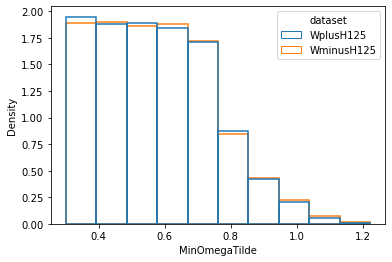

In [15]:
import seaborn as sns

sns.histplot(data=data.loc[(data["dataset"] ==  "WplusH125") | (data["dataset"] == "WminusH125")], x="MinOmegaTilde", hue="dataset", stat="density", log_scale=(False,False), common_norm=False, bins=10, fill=False)

In [32]:
os.listdir()

['.ipynb_checkpoints',
 'data_preprocessing-jvsc-42272eda-b10c-4f4b-9cb5-071b65596c5e.ipynb',
 'RNN_tuned_model',
 'combined_model_tuning.py',
 'basicNN_SemiLepton.ipynb',
 'RNN_model',
 'combined_analysis.ipynb',
 'RNN_analysis.ipynb',
 'untitled_project',
 'kt_RNN_MLP_1_classes',
 'first_RNN_stuff',
 'models',
 'CNN_play.ipynb',
 'RNN_tuning.ipynb',
 'plots',
 'train_combined_nn.py',
 'train_SimpleRNN.py',
 'kt_RNN_MLP_4_classes',
 'RNN_tuning.py',
 'RNN_02',
 'data_preprocessing.ipynb',
 'RNN.ipynb',
 'kt_RNN_MLP',
 'data',
 'tuning.sh']

In [17]:
import re

s = "QCD"
s_ = "QCD_HT1000to1500"

re.sub()

TypeError: sub() missing 1 required positional argument: 'string'

In [2]:
full_data = preprocess()

# y_train, y_test = full_data[0][-2], full_data[0][-1]
# print(f"""Training ratios:  {len(y_train[y_train['ttH125']==1])/len(y_train)}, {len(y_train[y_train['TTToHadronic']==1])/len(y_train)}, 
# {len(y_train[y_train['TTToSemiLeptonic']==1])/len(y_train)}, {len(y_train[y_train['TTTo2L2Nu']==1])/len(y_train)}""")
# print(f"""Test ratios:  {len(y_test[y_test['ttH125']==1])/len(y_test)}, {len(y_test[y_test['TTToHadronic']==1])/len(y_test)}, 
# {len(y_test[y_test['TTToSemiLeptonic']==1])/len(y_test)}, {len(y_test[y_test['TTTo2L2Nu']==1])/len(y_test)}""")
np.save("./data/full_data.npy", full_data[0])
np.save("./data/weights.npy", full_data[1])

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [2]:
new_sl = pd.read_hdf("/scratch/ys20884/ml_vars/ttBar/df_ml_inputs.hd5")
new_ttH = pd.read_hdf("/scratch/ys20884/ml_vars/ttH/df_ml_inputs.hd5")

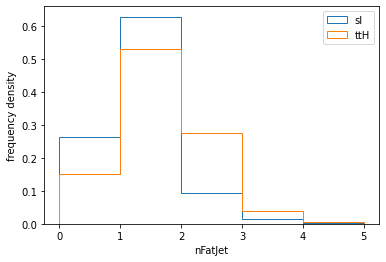

In [15]:
import matplotlib.pyplot as plt

plt.hist(new_sl['nFatJet'], label='sl', density=True, histtype='step', bins=range(6))
plt.hist(new_ttH['nFatJet'], label='ttH', density=True, histtype='step', bins=range(6))
plt.xlabel('nFatJet')
plt.ylabel("frequency density")
plt.legend()
plt.show()

In [14]:
new_data = pd.concat([new_sl, new_ttH], axis=0)
new_data['nFatJet'].describe()

count    395531.000000
mean          0.953336
std           0.689666
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: nFatJet, dtype: float64

In [9]:
np.save("./full_data_feb15.npy", full_data[0])
# np.save("./weights.npy", full_data[1])

In [3]:
datasets = ['ttH125', 'TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
data = pd.concat([get_data(dataset) for dataset in datasets], ignore_index=True)
labels = pd.get_dummies(data['dataset'])
data = data.join(labels)


In [6]:
data = data.drop(["hashed_filename", "entry", "weight_nominal"], axis=1)

In [8]:
data.to_hdf("./data/full_data.hd5", 'all')

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['dataset', 'cleanedJet_area', 'cleanedJet_btagDeepB',
       'cleanedJet_chHEF', 'cleanedJet_eta', 'cleanedJet_mass',
       'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt'],
      dtype='object')]

  encoding=encoding,


In [3]:
for dataset in datasets:
    print(f"{dataset}: count = {data[dataset].sum()}")

ttH125: count = 99305
TTToSemiLeptonic: count = 296226
TTToHadronic: count = 205
TTTo2L2Nu: count = 13236


In [3]:
arr = np.array([1,2,3])
np.tile(arr, 4)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])

<AxesSubplot:xlabel='BiasedDPhi', ylabel='Density'>

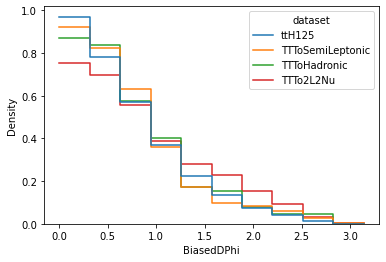

In [5]:
import seaborn as sns

data['BiasedDPhi'] = data["BiasedDPhi"].map(lambda x: x+np.pi if x < 0 else x)
sns.histplot(data, x="BiasedDPhi", hue="dataset", element="step", stat="density", common_norm=False, fill=False, bins=10)

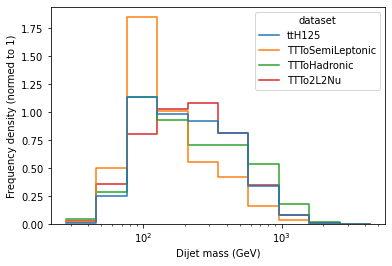

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(data, x="DiJet_mass", hue="dataset", element="step", stat="density", common_norm=False, fill=False, bins=10, log_scale=True, ax=ax)
ax.set_ylabel("Frequency density (normed to 1)")
ax.set_xlabel("Dijet mass (GeV)")
plt.savefig("../../histograms/DiJet_mass_density.png", dpi=200)
plt.show()


# sns.histplot(data, x="DiJet_mass", hue="dataset", element="step", stat="count", common_norm=False, fill=False)

In [14]:
data["DiJet_mass"].describe()

count    408972.000000
mean        213.928013
std         199.403298
min          27.644081
25%          91.114721
50%         133.625862
75%         269.223494
max        4355.463268
Name: DiJet_mass, dtype: float64

In [12]:
train_labels, test_labels = train_test_split(labels, random_state=42, stratify=labels['ttH125'])
train_labels

,TTTo2L2Nu,TTToHadronic,TTToSemiLeptonic,ttH125
130194,0,0,1,0
6136,0,0,0,1
168648,0,0,1,0
311994,0,0,1,0
29682,0,0,0,1
...,...,...,...,...
174931,0,0,1,0
175517,0,0,1,0
98871,0,0,0,1
122727,0,0,1,0


In [14]:
full_data[0][-2]

110193    0
301732    0
305801    0
1769      1
203489    0
         ..
174931    0
175517    0
24248     1
122727    0
78880     1
Name: ttH125, Length: 327177, dtype: uint8

In [6]:
s/np.sqrt(b)

5.470653048352906

In [10]:
full_data = preprocess()

/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [3]:
bg_datasets = ['TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
total_xs = []
n_examples = []
for bg in bg_datasets:
    df = get_data(bg)
    xs = df["xs_weight"].sum()
    total_xs.append(xs)
    n_examples.append(len(df))
print(total_xs)
print(n_examples)


[0.30719006, 0.00022454452, 0.01506993]
[296226, 205, 13236]


In [5]:
xs_ratios = [total_xs[i]/sum(total_xs) for i in range(3)]
n_ratios = [n_examples[i]/sum(n_examples) for i in range(3)]
print(xs_ratios)
print(n_ratios)


[0.9525729988784043, 0.0006962954709586545, 0.046730705650637]
[0.9565953104463827, 0.000662001440256792, 0.04274268811336048]


In [ ]:
full_data[0]

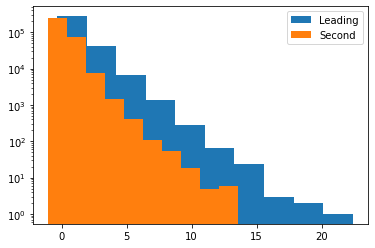

In [7]:
import matplotlib.pyplot as plt

obj_data = full_data[0][2]

#Leading Jet
plt.hist(obj_data[:, 0, -1], log=True, label="Leading")
plt.hist(obj_data[:,1,-1], log=True, label="Second")
plt.legend()
plt.show()

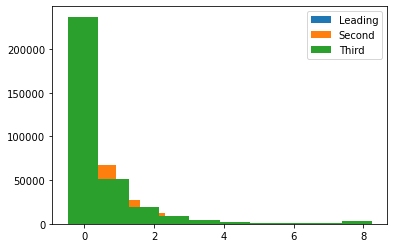

In [12]:
import matplotlib.pyplot as plt

obj_data = full_data[0][2]

# Leading Jet
plt.hist(obj_data[:, 0, -3], label="Leading")
plt.hist(obj_data[:,1,-3], label="Second")
plt.hist(obj_data[:, 2, -3], label="Third")
plt.legend()
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = full_data[0][0], full_data[0][1], full_data[0][-2], full_data[0][-1]
clf = LogisticRegression(random_state=1).fit(X_train, y_train)


In [6]:
scores = clf.predict_proba(X_test)
scores

array([[0.91904858, 0.08095142],
       [0.74095901, 0.25904099],
       [0.81094039, 0.18905961],
       ...,
       [0.95004988, 0.04995012],
       [0.69327869, 0.30672131],
       [0.43327449, 0.56672551]])

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])


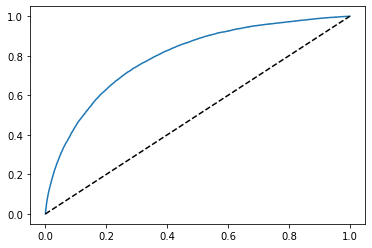

In [11]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0, 1, 100), linestyle="dashed", color="k")
plt.show()

In [13]:
roc_auc_score(y_test, scores[:,1])

0.7951071366216732

In [3]:
datasets = ['ttH125', 'TTToSemiLeptonic', 'TTToHadronic', 'TTTo2L2Nu']
data = pd.concat([get_data(dataset) for dataset in datasets], ignore_index=True)
data.columns

Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')

In [ ]:
np.save('full_data.npy', full_data[0])
np.save('weights.npy', full_data[1])

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential(
    layers.LSTM(32, input_shape=(14, 8)),
    layers.Dense(1, activation='sigmoid')
)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=keras.metrics.BinaryAccuracy(name='accuracy'))
print(model.summary)
# print('Hello world!')

2022-01-26 17:27:35.184367: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-01-26 17:27:35.231176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2022-01-26 17:27:35.237870: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560b0e1bf360 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-26 17:27:35.237906: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-26 17:27:35.240060: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module

Traceback (most recent call last):
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_103161/1877610519.py", line 6, in <module>
    layers.Dense(1, activation='sigmoid')
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/sequential.py", line 116, in __init__
    self.add(layer)
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/tensorflow_core/pyth

In [2]:
print(tf.__version__)

2.1.0


In [14]:
obj_train = full_data[0][2]
obj_train[:, 0, 7]



array([ 0.34737535, -0.93513631, -0.87114019, ..., -0.31020072,
       -0.85554891,  3.55868584])

In [5]:
for i in range(14):
    scaler = StandardScaler()
    obj_train[:, i, :] = scaler.fit_transform(obj_train[:, i, :])

In [20]:
import pandas as pd

dataset = 'ttH125'
data = pd.read_hdf(f'/storage/bk17414/ForStudents/2021_CMS_ML/ml_postproc/{dataset}/df_ml_inputs.hd5')
data.columns
# 8 x 14

Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')

In [18]:
arr = np.zeros((len(data), 14, 2))
arr[:, 0, 0] = data.iloc[:, 18].map(lambda x:x[2] if len(x) > 2 else 0)
arr


array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.02929688, 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       ...,

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.01293945, 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        .

In [3]:
from sklearn.model_selection import train_test_split

X, y = data.drop('dataset', axis=1), data['dataset']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_train.shape

NameError: name 'data' is not defined

RNN - want sequence of vectors 

In [25]:
data, weights = preprocess(['entry', 'hashed_filename', 'weight_nominal', 'InputMet_phi', 'MHT_phi', 'xs_weight', 'cleanedJet_area', 'cleanedJet_eta',
'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi', 'cleanedJet_pt', 'cleanedJet_btagDeepB', 'cleanedJet_chHEF'])
np.save('full_data_binary', data)
np.save('full_data_xs_weights', weights)

/software/ac18804/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
